In [1]:
import os

import pandas as pd
import numpy as np
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go

from tqdm import tqdm

In [2]:
from sklearn.metrics import mean_absolute_error

In [3]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

In [4]:
from oktmo_names import oktmo_names_decode as oktmo_names

In [5]:
from pylab import rcParams
rcParams['figure.figsize'] = 22, 7

In [6]:
#%pylab inline

In [7]:
PATH_DATA = os.path.join(Path.cwd(), 'data')
PATH_SUBM = os.path.join(Path.cwd(), 'submissions')

Read train data. Set type of all columns to float.

In [8]:
data2 = pd.read_csv(os.path.join(PATH_DATA, 'train.csv'),
                    sep = ';',
                    parse_dates=['date'],
                    infer_datetime_format=True,
                    decimal = ',',
                    thousands='\xa0',
                    engine='python',
                   )

items = data2.columns.drop(['region', 'oktmo', 'okato', 'date'])
for el in items:
    data2[el] = data2[el].astype(float)
    
data2.shape

(69785, 79)

In [9]:
dt = np.datetime64('2020-10-31')

In [10]:
train_df = data2.query('date <= @dt')
train_df.shape

(56950, 79)

In [11]:
test_df = data2.query('date > @dt')
test_df.shape

(12835, 79)

In [12]:
data2.date.max() - test_df.date.min(), test_df.date.min() - data2.date.min()

(Timedelta('150 days 00:00:00'), Timedelta('670 days 00:00:00'))

Get aver over all oktmo (except Ingush in set)

In [13]:
def get_aver(inp_prod, inp_df, ignore_Ingush = True):
    
    if ignore_Ingush:
        use_cols = ['date', inp_prod, 'oktmo']
        #ignore_oktmo = oktmo_names[26000000000]
        ignore_oktmo = 26000000000
        return inp_df[use_cols].query('oktmo != @ignore_oktmo')[['date', inp_prod]].groupby('date').mean().sort_values(by='date')
    
    use_cols = ['date', inp_prod]        
    return inp_df[use_cols].groupby('date').mean().sort_values(by='date')

Calculate deviation from aver over all oktmo over all products

In [68]:
def calculate_deviation_v2(inp_prod, inp_df):
    
    aver = get_aver(inp_prod, inp_df, True)
    
    deviation = {el: 0 for el in inp_df.oktmo.unique()}
    devider_const = inp_df.query('oktmo == @inp_df.oktmo.unique()[0]').shape[0]

    for reg in inp_df.oktmo.unique():
        devider = devider_const
        for idx in inp_df.query('oktmo == @reg').index:
            if inp_df.loc[idx, inp_prod] > 0:
                deviation[reg] += (inp_df.loc[idx, inp_prod] - aver.loc[inp_df.loc[idx, 'date']].values[0])
                #deviation[reg] += (inp_df.loc[idx, inp_prod] / aver.loc[inp_df.loc[idx, 'date']].values[0])
            else:
                devider -= 1
                
        if devider != 0: 
            deviation[reg] = deviation[reg] / devider
        else:
            deviation[reg] = 0
            
    return deviation

In [71]:
oktmo = data2.oktmo.unique()
deviation_df = pd.DataFrame(columns = list(items), index = oktmo)

In [72]:
for itm in tqdm(items):
    temp = calculate_deviation_v2(itm, train_df)
    #temp = calculate_deviation_v2(itm, data2)
    for el in temp.keys():
        deviation_df.loc[el, itm] = temp[el]
        
        

100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [09:56<00:00,  7.96s/it]


In [98]:
deviation_df.head()

,pasta,legumes,bread,flour,rice,groats,potatoes,сucumbers_tomatoes,vegetables,roots,...,spice_value,tea_value,ai92,ai95,ai98,dt,ai92_value,ai95_value,ai98_value,dt_value
71000000000,-4.716946,-2.472983,-5.778579,-2.726558,2.530546,-1.405188,-2.118342,-7.387124,-0.301409,-0.409199,...,902.823386,1459.941172,-1.179567,-0.341579,11.504123,1.147985,126924.042370,-1692.045832,-987.221631,-53763.720324
76000000000,-14.308319,9.737778,-5.055205,3.578547,-7.606931,-10.226517,4.124136,4.455488,-0.121289,7.193174,...,-19483.028704,-15763.133082,3.224359,1.487541,11.596413,5.728761,-258513.332675,-306598.979682,-100.007188,-128115.886459
75000000000,-4.568454,-4.687834,2.075138,-1.692125,-0.762722,-0.423979,-3.069103,-14.884303,-1.170633,-1.333856,...,36641.242326,34963.745784,-2.010149,-1.278937,9.389774,-0.097911,463085.747668,126573.814885,-3610.303944,46388.132944
73000000000,-11.670499,-19.457610,0.168123,-2.949304,-1.062081,-1.902323,-6.591655,-27.693662,-7.451827,-8.253169,...,-11074.810883,-9535.982739,-0.832268,-1.195086,7.831443,-1.753120,-109496.982227,-249221.051802,4768.096051,-96418.963220
64000000000,39.199098,9.809673,28.033227,13.007398,-49.431916,-29.412636,12.135210,48.917667,17.005830,22.065607,...,-25595.255659,-25042.731739,5.134881,1.868197,12.748846,7.876761,-340554.726287,-289879.261175,18937.472275,-129785.851563


In [83]:
deviation_df.to_csv(os.path.join(PATH_DATA, 'deviation_sum_nz.csv'))
#deviation_df.to_csv(os.path.join(PATH_DATA, 'deviation_mult_nz.csv'))

In [97]:
if os.path.exists(os.path.join(PATH_DATA, 'deviation_sum_nz.csv')):
    deviation_df = pd.read_csv(os.path.join(PATH_DATA, 'deviation_sum_nz.csv'),
#if os.path.exists(os.path.join(PATH_DATA, 'deviation_mult_nz.csv')):
    #deviation_df = pd.read_csv(os.path.join(PATH_DATA, 'deviation_mult_nz.csv'),
                              index_col = 0,
                              )

Make future dates from 01.04.2021 to 30.06.2021 

In [91]:
X = get_aver('fruit_value', train_df)
X = X.reset_index()[['date', 'fruit_value']]
X.columns=['ds', 'y']

In [92]:
model = Prophet(yearly_seasonality=True, daily_seasonality=True)
model.fit(X)

In [93]:
future = model.make_future_dataframe(periods = test_df.date.unique().shape[0])
future = future[train_df.date.unique().shape[0]:]

Make models (without saving) and submissions

Для каждого прогнозируемого показателя (столбца) рассчитывается его среднее значение v_mean j  и значение метрики MAE: v_mae j   
Для каждого показателя вычисляется отношение   
E j  = v_mae j  / v_mean j    
Рассчитывается среднее значение E среди всех столбцов    
E_mean = 1 / n * sum(E j )   
Берется обратная величина и делится на константу 1000   
score = 1 / (1000 * E_mean)   

In [119]:
ej = list()
for itm in tqdm(items):
    train = get_aver(itm, train_df)
    X = train.reset_index()[['date', itm]]#.columns = ['ds', 'y']
    X.columns=['ds', 'y']
    
    model = Prophet(yearly_seasonality=True, daily_seasonality=True,
                    seasonality_mode='multiplicative',  # hz. future firecast more sharp
                    #changepoint_prior_scale=0.01,   # 0.1 - 0.15 looks adequately
                   )
    #model.add_country_holidays(country_name='RUS')
    model.fit(X)
    
    forecast = model.predict(future)
    
    for reg in oktmo:
        mult = deviation_df.loc[reg, itm]
        v_mae_j  = mean_absolute_error( test_df.loc[test_df.oktmo == reg, itm], forecast.yhat.values + mult)
        #v_mae_j  = mean_absolute_error( test_df.loc[test_df.oktmo == reg, itm], forecast.yhat.values * mult)
        v_mean_j  = np.mean(forecast.yhat.values + mult)
        ej.append(v_mae_j / v_mean_j)

100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [04:37<00:00,  3.70s/it]


In [120]:
e_mean = np.mean(ej)
score  = 1 / (1000 * e_mean)

In [121]:
print(score, e_mean)

0.007255538811052343 0.1378257392099816


###             score                   e_mean

### train only
### sum   0.0040245531283539734   0.24847479163705216
### mult  0.003815094358441031    0.26211671482973015

## train only with no zeros in calculate_deviation
### sum   0.006017705294428927    0.16617629994705463
### mult  0.0035103260917527467   0.28487381908747067

### full df in calculate_deviation with no zeros / train_df in score.
### sum   0.0035765198565263024   0.279601411460148
### mult  0.0035410576431147674   0.282401502823429

### full df in calculate_deviation with no zeros / train_df in score.
### seasonality_mode='multiplicative', changepoint_prior_scale=0.15
### sum  -0.0006290557994611276  -1.5896840961590957
### mult  0.0024723274405891566   0.4044771673778371

### full df in calculate_deviation with no zeros / train_df in score + holidays = RUS
### sum   0.002629574524820236    0.38028965924377534

### train only with no zeros in calculate_deviation / train_df in score.
### seasonality_mode='multiplicative'
### sum   0.007255538811052343    0.1378257392099816

In [27]:
submission.head()

NameError: name 'submission' is not defined

In [ ]:
submission.to_csv()

In [ ]:
forecast.yhat.values + mult

In [ ]:
mean_absolute_error()

# below this level - trash. do not used

In [42]:
train = get_aver('fruit_value', data2)
train.shape

(821, 1)

In [43]:
train.head()

,fruit_value
date,
2019-01-01,22482.123810
2019-01-02,54029.372619
2019-01-03,65719.328571
2019-01-04,75997.832143
2019-01-05,83527.400000


<AxesSubplot:xlabel='date'>

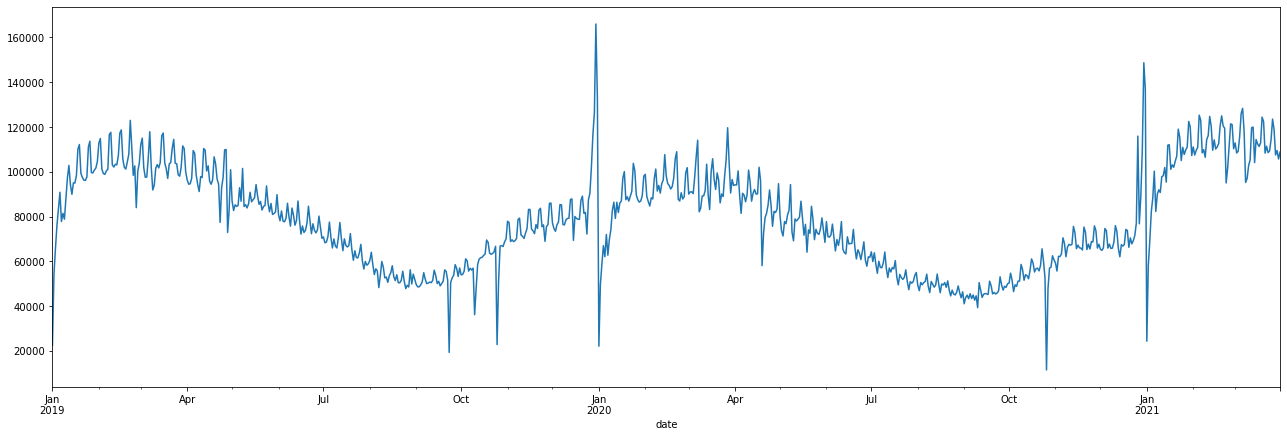

In [44]:
train.fruit_value.plot()

In [45]:
X = train.reset_index()[['date', 'fruit_value']]#.columns = ['ds', 'y']
X.columns=['ds', 'y']
X.head()

,ds,y
0,2019-01-01,22482.123810
1,2019-01-02,54029.372619
2,2019-01-03,65719.328571
3,2019-01-04,75997.832143
4,2019-01-05,83527.400000


In [51]:
model = Prophet(
                #seasonality_mode='multiplicative',
                daily_seasonality=True,
               )

model2 = Prophet(
                #seasonality_mode='multiplicative',  # hz. future firecast more sharp
                #changepoint_prior_scale=0.15,   # 0.1 - 0.15 looks adequately
                #growth='logistic',
                daily_seasonality=True,
               )
model2.add_country_holidays(country_name='RUS')

In [52]:
#model.fit(X)
model2.fit(X)

In [53]:
future = model2.make_future_dataframe(periods=91)
#print(future.shape)
#future = future[821:]

In [54]:
#forecast = model.predict(future)
forecast2 = model2.predict(future)

In [56]:
model2.train_holiday_names

0                   Новый год
1      Православное Рождество
2    День защитника отечества
3                 День женщин
4      Праздник Весны и Труда
5                 День Победы
6                 День России
7     День народного единства
dtype: object

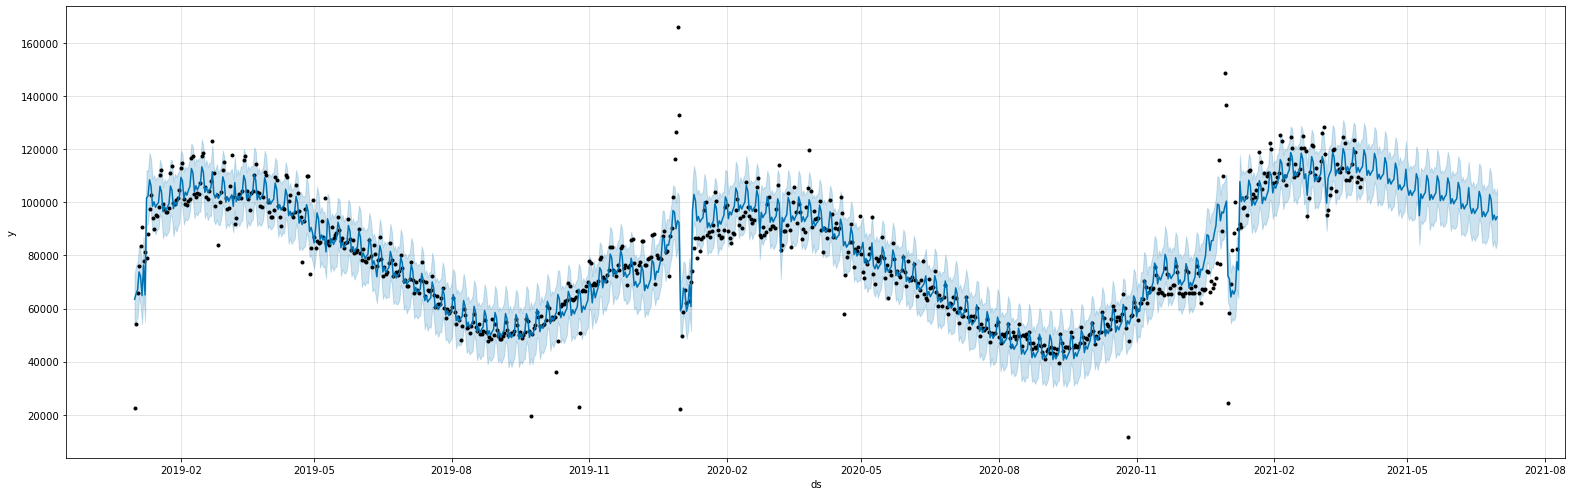

In [55]:
fig12 = model2.plot(forecast2, figsize = (22, 7))
#a=add_changepoints_to_plot(fig1.gca(),model,forecast)

In [ ]:
fig1 = model.plot(forecast, figsize = (22, 7))

In [ ]:
fig2 = model.plot_components(forecast, figsize = (22, 21))

In [ ]:
fig22 = model2.plot_components(forecast2, figsize = (22, 21))

In [ ]:
forecast['ds']

In [ ]:
fig = px.line(x = forecast['ds'], y = forecast['yhat'])
fig.show()

In [ ]:
fig = px.line(x = forecast['ds'], y = forecast['yhat'])
fig.show()

In [ ]:
Xfull.fruit.mean(), Xtrue.fruit.mean()

In [ ]:
Xfull = get_aver('fruit', ignore_Ingush = False)
Xtrue = get_aver('fruit', ignore_Ingush = True)

In [ ]:
fig = px.line(y = Xfull.fruit, x = Xfull.index)
#fig.add_scatter(px.line(Xtrue))
fig.add_trace(go.Scatter(y = Xtrue.fruit, x = Xtrue.index))
fig.show()

In [ ]:
Xfull.index
#Xtrue.index

In [ ]:
fig = px.line(y = Xfull.fruit, x= Xfull.index)
fig.show()

In [ ]:
fig = px.line(y = Xtrue.fruit, x= Xtrue.index)
fig.show()